**# TC 5033**
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset


Héctor Raúl Vázquez González - A00565542

Ronald David Zuniga Sánchez - A01686240

Sergio Omar Esparza Hernández  - A01794338

Hugo Enrique Solano Ortega - A01794456


- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline

##################################
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt: ignored

In [ ]:
#DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
#DATA_PATH = '/home/pepe/Documents/github_repos/datasets/asl_data'
#DATA_PATH = '/content/drive/MyDrive/ColabFiles/asl_data/'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/ML2/Act01b/asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Import images

Let's obtain the training and validation data.
We will use y_train/y_val to get the class of the entry. x_train/x_val will contain the pixel information of input image

In [ ]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [ ]:
x_train.shape

(27455, 784)

In [ ]:
x_val.shape

(7172, 784)

We will use the unique function to know how many different classes of images the validation data set has

In [ ]:
print("Number of classes : "+ str(len(np.unique(y_val))))

Number of classes : 24


In [ ]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Function that allows to split the previously loaded validation set
    into valition and test.
    '''

    #Get the number of elements of the data
    total = x.shape[0]
    #Create an array with all the indices to be used
    indices = np.arange(total)
    if shuffle:
        np.random.shuffle(indices)

    #After shuffling, we will re-assign the x and y arrays accordingly
    x = x[indices]
    y = y[indices]

    #We are going to take the first portion (%) of the data as validation
    x_val = x[:int(total*pct)]
    y_val = y[:int(total*pct)]
    #The remaining data will be used as test data
    x_test = x[int(total*pct):]
    y_test = y[int(total*pct):]

    return x_val, y_val, x_test, y_test

In [ ]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [ ]:
#As the output or classes are represented with a number, We will assign a letter to each index.
#Removing 'j' and 'z' as they cannot be represented using one single image
#By checking the length of the "alphabet" array, we will make sure it matches with the number of classes

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24



### Normalise

In [ ]:
#Z-score normalization will be used.
def normalise(x_mean, x_std, x_data): return (x_data - x_mean) / x_std

#train data will be use to get the mean and standard deviation to compare with
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [ ]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Function to plot the image

In [ ]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: i


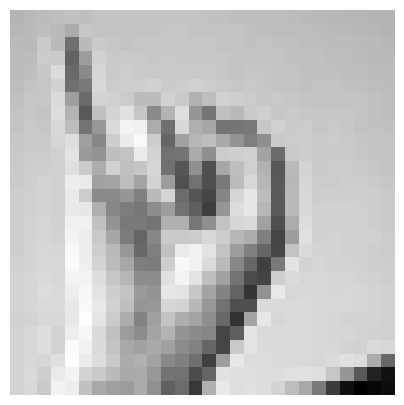

In [ ]:
#We will create a random image and show what letter is representing
rnd_idx = np.random.randint(len(y_test))
print(f'Image shown represents: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))

### Model's equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Additional functions

#### Mini batches

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    This function will create a number of batches defined by total_data/mb_size
    The function will return what index to use to access to the batches
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [ ]:
#In order to have customizable class, we will inherit the class ndarray
class np_tensor(np.ndarray): pass

## Classes: Linear, ReLU and Sequential

###  Linear class

In [ ]:
#Defining the class to use as layer.
#Including forward (by using the __call__ method) and backward method
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X):
        Z = self.W @ X + self.b
        return Z
    #Using the attribute 'grad' in our class to save the gradient of the cost function in order to implement the backward pass
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

### ReLU class

In [ ]:
#Defining the class to use as Activation function
#Including forward (by using the __call__ method) and backward method
class ReLU():
    #This part returns the value of Z when Z is >= 0 or return 0 if Z is a negative value
    def __call__(self, Z):
        return np.maximum(0, Z)
    #For Z values lower than 0, the gradient will be 0. Positive Z values will remain as they are
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Sequential class

In [ ]:
#This class will be used as the container of all the layers used in the model
class Sequential_layers():
    def __init__(self, layers):
        '''
        This class contains the list of layers to use, they can be either Linear or ReLU classes
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        #Assigning manually the first element
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x) #Will use the forward method
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))): #Using "reversed" to go backwards
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [ ]:
#This function calculates the softmax activation function. Then we calculate the cost function
#which translates the outputs to probabilities
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Cost
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Gradient calculation
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Training loop

In [ ]:
#Function to train the model
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        #We will use the generator defined above to create the mini batches
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'cost: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
#Function to calculate the accuracy of the model
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

### Create your model and train it

In [ ]:
#Linear(784,_) -> 784 pixels as input
#Linear(_, 24) -> 24 as the number of classes
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 100), ReLU(), Linear(100, 50), ReLU(), Linear(50, 24)])
mb_size = 128
learning_rate = 1e-3
epochs = 20


In [ ]:
train(model, epochs, mb_size, learning_rate)

cost: 0.04577510217381775, accuracy: 0.7721695482431679
cost: 0.011675839705128433, accuracy: 0.7872281093139989
cost: 0.0037985617805750002, accuracy: 0.790574456218628
cost: 0.001972364468180372, accuracy: 0.7900167317345231
cost: 0.00226985706613286, accuracy: 0.7914110429447853
cost: 0.0026657361802970487, accuracy: 0.7894590072504183
cost: 0.002200009772672178, accuracy: 0.7944785276073619
cost: 0.0009986092392064642, accuracy: 0.7936419408812047
cost: 0.0010529813631189363, accuracy: 0.7950362520914668
cost: 0.0011028049710363368, accuracy: 0.7953151143335192
cost: 0.0006527620292398594, accuracy: 0.7944785276073619
cost: 0.0008203073796283321, accuracy: 0.7955939765755716
cost: 0.0004695646278285498, accuracy: 0.7961517010596765
cost: 0.0006646229141200943, accuracy: 0.7953151143335192
cost: 0.0006015026003793512, accuracy: 0.7961517010596765
cost: 0.0008567647940425302, accuracy: 0.7950362520914668
cost: 0.0007116304024835374, accuracy: 0.7967094255437813
cost: 0.00036857369668

### Test your model on Random data from your test set

In [ ]:
print(accuracy(x_test, y_test, mb_size))

0.7849972113775795


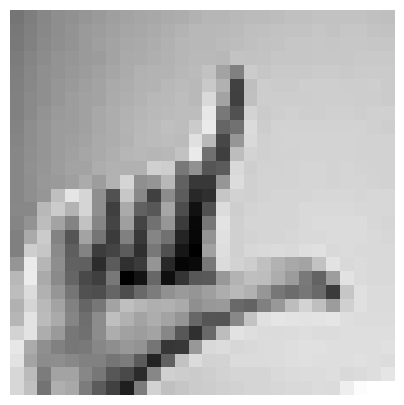

el valor predicho es: l el valor real es:l


In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'Predicted value: {alphabet[pred]} real value:{alphabet[y_test[idx]]}')